<a href="https://colab.research.google.com/github/Dezyderata/NAI_lab1/blob/master/Copy_of_lab1_szablon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laboratorium 1: NAI
Wprowadzenie do algorytmów genetycznych na przykładzie problemu komiwojażera.

In [0]:
import numpy as np, random, operator
import pandas as pd
import matplotlib.pyplot as plt
from random import sample, randint
from itertools import cycle
from copy import deepcopy

## Stworzenie klas i wymaganych funkcji

In [0]:
# Klasa reprezentująca pojedyncze miasto, miasto reprezentowane jest przez 
# współrzędne x, y.
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        # Zad 1: Oblicz odległość euklidesową pomiędzy miastami - 1 ptk
        distance = 0
        distance = ((city.x - self.x)**2 + (city.y - self.y)**2)**0.5
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [0]:

# Klasa obliczająca dopasowanie wykorzystując miarę odległości.
class Fitness:
    def __init__(self, route):
        # Route jest to lista obiektow City, o wspolrzednych x i y
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            # Zad 2. Oblicz całkowitą trasę (route) - 1 ptk
            counter = 1
            for city in self.route:
                if counter == len(self.route):
                    pathDistance += city.distance(self.route[0])
                else:
                    pathDistance += city.distance(self.route[counter])
                    counter += 1
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            # Funkcja dopasowania jest odwrotnością długości trasy.
            # W problemie komiwojażera minimalizujemy odlegość między miastami,
            # stąd im większa jest wartość funkcji dopasowania tym lepiej.
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [0]:
# Zad 2. Przykladowa lista miast - sprawdzenie czy funkcja Fitness poprawnie oblicza odleglosc
assert(City(1,2).distance(City(5, 5)) == City(5,5).distance(City(1,2)) == 5)
assert(Fitness([City(0,0), City(1, 0), City(1, 1), City(0, 1)]).routeDistance() == 4)
assert(Fitness([City(0,0),City(0,2), City(0, 4), City(0, 6), City(0, 8)]).routeDistance() == 16)

## Stwórz populację początkową

In [0]:
def initialPopulation(popSize, cityList):
    # popSize - rozmiar populacji początkowej
    # cityList - lista miast
    population = []
    for pop in range(popSize):
        population.append(sample(cityList, len(cityList)))
    # Zadanie 3: Stwórz populację początkową, zwróć listę list populacji.
    # Wskazowka: Wykorzystaj funkcję `random.sample` - 1 ptk
    return population


## Implementacja algorytmu genetycznego

In [0]:
# Obliczanie funkcji dopasowania dla populacji. Zwracany jest posortowany słownik,
# względem malejącej funkcji dopasowania.
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [0]:

# Stworzenie zbioru rodzicow, ktory bedzie wykorzystany w reprodukcji.
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [0]:
def breed(parent1, parent2):
    # Zdanie 5: Zaimplementuj operacje krzyzowania - 2 ptk
    visited = set()
    border1 = randint(0,len(parent1)-1)
    border2 = randint(border1+1, len(parent1))
    lparent = len(parent1)
    child = [0]*len(parent1)
    counter = border1
    for i in range(border1, border2):
        child[i] = parent1[i]
        visited.add(parent1[i])
    j = border2%lparent
    k = j
    while k != border1:
      if parent2[j] not in visited:
        child[k] = parent2[j]
        k = (k+1)%lparent
      j = (j+1)%lparent
        
    return child        
        


In [17]:
    parent1 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    parent2 = [9, 8, 7, 6, 5, 4, 3, 2, 1]
    print(breed(parent1, parent2))

[9, 8, 3, 4, 5, 6, 7, 2, 1]


In [0]:
# Funkcja obliczająca krzyżowanie dla całej populacji.
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [0]:
def mutate(individual, mutationRate):
    # Zadanie 6: Zaimplementuj operacje mutacji. Mutacja umozliwia przeszukanie
    # nowej przestrzeni drog. W pojedynczej operacji mutacji zamieniamy dwa miasta
    # losowo wybrane. Miasta sa zamieniane wtedy, kiedy zmienna losowa jest mniejsza
    # od mutationRate. - 2 ptk
    random_variable = random.uniform(0,1)
    if random_variable < mutationRate:
      indexes = random.sample(range(len(individual)), 2)
      individual[indexes[0]], individual[indexes[1]]= individual[indexes[1]], individual[indexes[0]]
    return individual

In [0]:
# Funkcja, ktora uruchamia operacje mutacji dla calej populacji.
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [0]:
# Glowna funkcja implementujaca algorytm genetyczny.
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        pop = nextGeneration_tournament(pop, eliteSize, mutationRate)
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute


# tournament selection

In [0]:
def selection_tournament(popRanked, eliteSize):
    selectionResults = []
    for i in range(eliteSize):
      selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked) - eliteSize):
      sam = sample(popRanked, 7)
      winner = max(sam, key = lambda x : x[1])[0]
      selectionResults.append(winner)
    return selectionResults

In [0]:
def nextGeneration_tournament(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection_tournament(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [0]:
# Zadanie 8*: Zaimplementuj funkcje, ktora bedzie rysowala w jaki sposob
# zmienia sie odleglosc w kazdej generacji. Os X niech reprezentuje numer generacji,
# a os Y - niech reprezentuje odleglosc. - 2 ptk
#tourment
def geneticAlgorithmPlot_tournament(pop, population, popSize, eliteSize, mutationRate, generations):
#     pop = initialPopulation(popSize, population)
    print("tournament")
    steps = []
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        steps.append(1 / rankRoutes(pop)[0][1])
        pop = nextGeneration_tournament(pop, eliteSize, mutationRate)
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    steps.append(1 / rankRoutes(pop)[0][1])
    printAll(steps)
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# roulette wheel sellection

In [0]:
def selection_roulette(popRanked, eliteSize):
    selectionResults = []
    for i in range(eliteSize):
      selectionResults.append(popRanked[i][0])
    fitness_sum = np.sum(popRanked, axis = 0)[1]
    sum_of_probabilities = 0
    probabilities_list = []
    for index, value in popRanked[::-1]:
      probabilities_list.append((index, sum_of_probabilities+(value/fitness_sum)))
      sum_of_probabilities = probabilities_list[-1][1]
    for i in range(len(popRanked) - eliteSize):
      num = random.uniform(0,1)
      if num < probabilities_list[0][1]:
        selectionResults.append(probabilities_list[0][0])
      elif num > probabilities_list[-1][1]:
        selectionResults.append(probabilities_list[-1][0])
      else:
        probabilities_list_cycle = cycle(probabilities_list)
        item = next(probabilities_list_cycle)
        while True:
          next_item = next(probabilities_list_cycle)
          if item[1] < num and next_item[1] > num:
            selectionResults.append(next_item[0])
            break
          item, next_item = next_item, next(probabilities_list_cycle)
    return selectionResults

In [0]:
def nextGeneration_roulette(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection_roulette(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [0]:
def geneticAlgorithmPlot_roulette(pop, population, popSize, eliteSize, mutationRate, generations):
    steps = []
    print("roulette")
#     pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        steps.append(1 / rankRoutes(pop)[0][1])
        pop = nextGeneration_roulette(pop, eliteSize, mutationRate)
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    steps.append(1 / rankRoutes(pop)[0][1])
    printAll(steps)
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# rank selection

In [0]:
def selection_rank(popRanked, eliteSize):
    selectionResults = []
    for i in range(eliteSize):
      selectionResults.append(popRanked[i][0])
    probabilities_list = []
    rank_sum = (len(popRanked)+1)*len(popRanked)/2
    probabilities_list = [(float(a)/rank_sum,b[0]) for a, b in zip(range(len(popRanked),0,-1), popRanked)]
    for i in range(len(popRanked) - eliteSize):
      num = random.uniform(0,1)
      prob = 0
      for i in probabilities_list:
        prob += i[0]
        if num < prob:
          selectionResults.append(i[1])
          break
    return selectionResults


In [0]:
def nextGeneration_rank(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection_rank(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [0]:
def geneticAlgorithmPlot_rank(pop, population, popSize, eliteSize, mutationRate, generations):
    steps = []
    print("rank")
#     pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        steps.append(1 / rankRoutes(pop)[0][1])
        pop = nextGeneration_rank(pop, eliteSize, mutationRate)
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    steps.append(1 / rankRoutes(pop)[0][1])
    printAll(steps)
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## auxiliary functions

In [0]:
def drawSingleRoute(route):
  
  x_coords = []
  y_coords = []
  for city in route:
    x_coords.append(city.x)
    y_coords.append(city.y)
  x_coords.append(route[0].x)
  y_coords.append(route[0].y)
  plt.plot(x_coords, y_coords, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
  plt.show()

  # Zadanie 7: Zaimplementuj funkcję rysującą trasę komiwojażera.
  # Hint: możesz wykorzystać biblioteke matplotlib.pyplot - 1 ptk

In [0]:
# Zadanie 9**: Zaimplementuj rozne rodzaje algorytmu selekcji i porownaj
# w jaki sposob zmienia sie funkcja przystosowania, jak szybko otrzymujemy coraz

# to lepsze wyniki. - 3 ptk
def printAll(steps):
  
  y_pos = list(range(len(steps)))
  plt.bar(y_pos, steps, align='center', alpha=0.5)
  plt.axis([-1, len(steps), min(steps)-100, max(steps)+100])
  plt.xlabel('generation')
  plt.ylabel('distance')
  
  plt.show()


# Uruchomienie algorytmu genetycznego

In [0]:
# Stworzenie listy miast, na poczatek 25 miast wraz z inicjacją pierwotnej populacji, co umożliwi porównanie sposobów selekcji
cityList = []
for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
pop = initialPopulation(100, cityList)


Initial distance: 2066.3574225945213
Final distance: 1052.384359771778


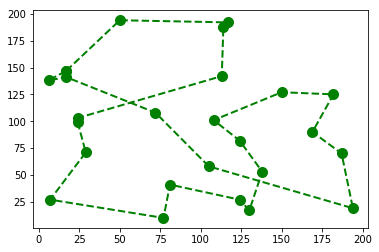

In [38]:
#bez rysowania kolejnych generacji. Rodzaj selekcji: turniej
bestRoute = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

drawSingleRoute(bestRoute)

## Różne algorytmy selekcji wraz z rysowaniem postępu

tourment
Initial distance: 1985.8621115936066
Final distance: 1017.9371190092922


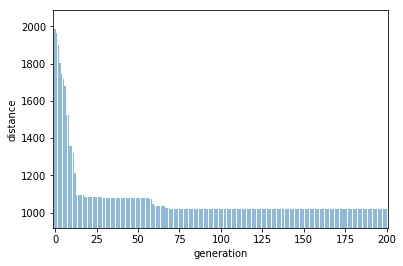

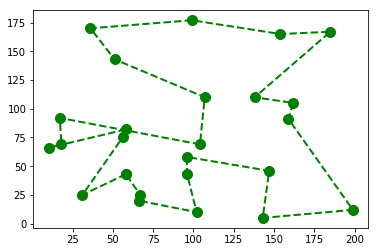

In [51]:
bestRoute_tournament = geneticAlgorithmPlot_tournament(pop, population=cityList, popSize=100, eliteSize=20, mutationRate=0.02, generations=200)

drawSingleRoute(bestRoute_tournament)

roulette
Initial distance: 1985.8621115936066
Final distance: 971.6214248402515


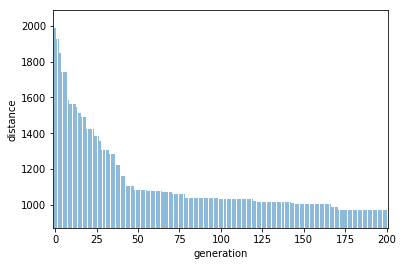

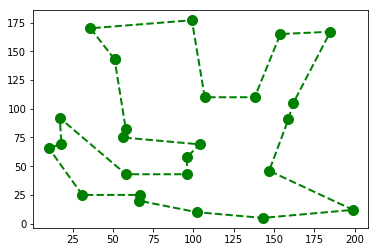

In [52]:
bestRoute_roulette = geneticAlgorithmPlot_roulette(pop, population=cityList, popSize=100, eliteSize=20, mutationRate=0.02, generations=200)

drawSingleRoute(bestRoute_roulette)

rank
Initial distance: 1985.8621115936066
Final distance: 1067.258333674759


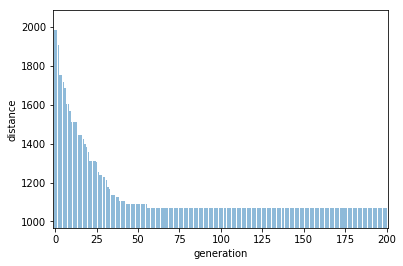

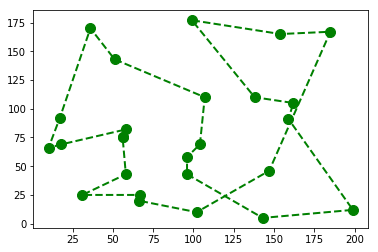

In [53]:
bestRoute_rank = geneticAlgorithmPlot_rank(pop, population=cityList, popSize=100, eliteSize=20, mutationRate=0.02, generations=200)

drawSingleRoute(bestRoute_rank)

# analysis of convergence times of solutions and achieved results 

In [0]:
city_list = []
for i in range(0,25):
    city_list.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
popu = initialPopulation(100, city_list)

In [0]:
def geneticAlgorithmAnalysis_tournament(pop, population, popSize, eliteSize, mutationRate, generations):
    steps = []
    convergence = 0
    for i in range(generations):
        steps.append(1 / rankRoutes(pop)[0][1])
        if len(steps) >= 2:
          if steps[-1] < steps[-2]:
            convergence = 0
          else:
            convergence += 1
        pop = nextGeneration_tournament(pop, eliteSize, mutationRate)
    steps.append(1 / rankRoutes(pop)[0][1])
    return 1 / rankRoutes(pop)[0][1], convergence

In [0]:
def geneticAlgorithmAnalysis_roulette(pop, population, popSize, eliteSize, mutationRate, generations):
    steps = []
    convergence = 0
    for i in range(generations):
        steps.append(1 / rankRoutes(pop)[0][1])
        if len(steps) >= 2:
          if steps[-1] < steps[-2]:
            convergence = 0
          else:
            convergence += 1
        pop = nextGeneration_roulette(pop, eliteSize, mutationRate)
    steps.append(1 / rankRoutes(pop)[0][1])
    return 1 / rankRoutes(pop)[0][1], convergence

In [0]:
def geneticAlgorithmAnalysis_rank(pop, population, popSize, eliteSize, mutationRate, generations):
    steps = []
    convergence = 0
    for i in range(generations):
        steps.append(1 / rankRoutes(pop)[0][1])
        if len(steps) >= 2:
          if steps[-1] < steps[-2]:
            convergence = 0
          else:
            convergence += 1
        pop = nextGeneration_rank(pop, eliteSize, mutationRate)
    steps.append(1 / rankRoutes(pop)[0][1])
    return 1 / rankRoutes(pop)[0][1], convergence

# mutation rate 2%

In [100]:
tournament = []
for _ in range(20):
  tournament.append(geneticAlgorithmAnalysis_tournament(deepcopy(popu), population=cityList, popSize=100, eliteSize=20, mutationRate=0.02, generations=100))
print(tournament)
print(f"tournament \ngenerations to convergence: min: {np.min(tournament, axis = 0)[1]}, average: {(np.sum(tournament, axis = 0)[1])/len(tournament)}, max: {np.max(tournament, axis = 0)[1]}")
print(f"best routes: min: {np.min(tournament, axis = 0)[0]}, average: {(np.sum(tournament, axis = 0)[0])/len(tournament)}, max: {np.max(tournament, axis = 0)[0]}")

[(1119.1010843320362, 28), (1191.016701251681, 20), (1280.949110047939, 8), (1240.6252610670504, 7), (1183.2527620638512, 20), (992.1333309769939, 22), (945.5931844598781, 20), (970.958305400124, 36), (1264.6951090706548, 71), (1057.4121692889964, 72), (1092.261564187376, 52), (1011.5310962201995, 12), (1207.0451738237034, 3), (1000.2892763881582, 71), (1212.209918886375, 13), (1126.0506397675108, 45), (1140.508142875612, 0), (989.4732714604836, 14), (1051.4629870480437, 5), (1127.0093957198765, 38)]
tournament 
generations to convergence: min: 0.0, average: 27.85, max: 72.0
best routes: min: 945.5931844598781, average: 1110.1789242168272, max: 1280.949110047939


In [101]:
roulette = []
for _ in range(20):
  roulette.append(geneticAlgorithmAnalysis_roulette(deepcopy(popu), population=cityList, popSize=100, eliteSize=20, mutationRate=0.02, generations=100))
print(roulette)
print(f"roulette selection \ngenerations to convergence: min: {np.min(roulette, axis = 0)[1]}, average: {(np.sum(roulette, axis = 0)[1])/len(roulette)}, max: {np.max(roulette, axis = 0)[1]}")
print(f"best routes: min: {np.min(roulette, axis = 0)[0]}, average: {(np.sum(roulette, axis = 0)[0])/len(roulette)}, max: {np.max(roulette, axis = 0)[0]}")

[(994.9661737587049, 3), (983.3260929746331, 1), (1048.9109344623314, 5), (988.8928099510382, 3), (942.8658232467426, 11), (986.3886938536393, 3), (1060.5537266738643, 17), (1087.8906861597166, 18), (983.6291802123235, 11), (1040.4422228959668, 17), (1013.2141630651113, 18), (906.9260657930935, 9), (974.6902869034063, 2), (891.8411695608477, 2), (958.8391259579811, 17), (993.5066119525154, 32), (897.2503105787599, 10), (996.2674975751554, 10), (891.8411695608478, 2), (993.4430745575422, 6)]
roulette selection 
generations to convergence: min: 1.0, average: 9.85, max: 32.0
best routes: min: 891.8411695608477, average: 981.7842909847108, max: 1087.8906861597166


In [102]:
rank = []
for _ in range(20):
  rank.append(geneticAlgorithmAnalysis_rank(deepcopy(popu), population=cityList, popSize=100, eliteSize=20, mutationRate=0.02, generations=100))
print(rank)
print(f"rank selection \ngenerations to convergence: min: {np.min(rank, axis = 0)[1]}, average: {(np.sum(rank, axis = 0)[1])/len(rank)}, max: {np.max(rank, axis = 0)[1]}")
print(f"best routes: min: {np.min(rank, axis = 0)[0]}, average: {(np.sum(rank, axis = 0)[0])/len(rank)}, max: {np.max(rank, axis = 0)[0]}")

[(961.476656220936, 2), (1029.6969962214991, 44), (1025.361733055325, 9), (996.2250230805029, 14), (1057.5873489785797, 12), (1034.05508888478, 51), (1005.1287526187851, 37), (1079.731292294954, 23), (1018.4061917309084, 54), (934.68497115846, 33), (952.3128309410926, 5), (975.4396861838252, 15), (981.4863647454749, 45), (1013.0456226611483, 27), (1099.8127649558965, 10), (1018.5277760689381, 54), (1021.8958333568495, 23), (964.499272626484, 12), (1170.9440142040708, 37), (964.9929866568588, 21)]
rank selection 
generations to convergence: min: 2.0, average: 26.4, max: 54.0
best routes: min: 934.68497115846, average: 1015.2655603322685, max: 1170.9440142040708


# mutation rate 1%

In [104]:
tournament = []
for _ in range(20):
  tournament.append(geneticAlgorithmAnalysis_tournament(deepcopy(popu), population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100))
print(tournament)
print(f"tournament \ngenerations to convergence: min: {np.min(tournament, axis = 0)[1]}, average: {(np.sum(tournament, axis = 0)[1])/len(tournament)}, max: {np.max(tournament, axis = 0)[1]}")
print(f"best routes: min: {np.min(tournament, axis = 0)[0]}, average: {(np.sum(tournament, axis = 0)[0])/len(tournament)}, max: {np.max(tournament, axis = 0)[0]}")

[(1077.2401889697576, 40), (1057.8906767554188, 76), (1047.6711936381575, 63), (1173.704815156308, 79), (1071.282392954165, 57), (1185.2917459029647, 33), (1118.233250190499, 28), (1137.4839006936584, 28), (1080.3385059000398, 55), (1125.8496673501024, 3), (1176.3915128301044, 67), (1060.1025923234208, 2), (1399.7575418803501, 0), (1033.7587211810742, 19), (1021.2207572438556, 16), (1023.4196362014193, 2), (1106.4375978867317, 68), (1361.7877535996563, 36), (1167.4943956980144, 49), (1151.4981574146714, 55)]
tournament 
generations to convergence: min: 0.0, average: 38.8, max: 79.0
best routes: min: 1021.2207572438556, average: 1128.8427501885185, max: 1399.7575418803501


In [105]:
roulette = []
for _ in range(20):
  roulette.append(geneticAlgorithmAnalysis_roulette(deepcopy(popu), population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100))
print(roulette)
print(f"roulette selection \ngenerations to convergence: min: {np.min(roulette, axis = 0)[1]}, average: {(np.sum(roulette, axis = 0)[1])/len(roulette)}, max: {np.max(roulette, axis = 0)[1]}")
print(f"best routes: min: {np.min(roulette, axis = 0)[0]}, average: {(np.sum(roulette, axis = 0)[0])/len(roulette)}, max: {np.max(roulette, axis = 0)[0]}")

[(906.9260657930935, 34), (1031.979390419907, 1), (891.8411695608478, 7), (972.6298122724311, 14), (993.852279942499, 40), (1046.8374345537397, 2), (941.9611205074149, 2), (898.2755877147741, 18), (1012.1210422374104, 6), (1040.777091924438, 41), (1018.5262797259105, 29), (989.9861796253095, 0), (1208.09195144449, 0), (1017.5592709869716, 9), (992.1245368415467, 3), (891.8411695608478, 22), (897.2503105787599, 11), (996.6802177463109, 1), (937.187387418296, 23), (1000.2437843579662, 6)]
roulette selection 
generations to convergence: min: 0.0, average: 13.45, max: 41.0
best routes: min: 891.8411695608478, average: 984.334604160648, max: 1208.09195144449


In [106]:
rank = []
for _ in range(20):
  rank.append(geneticAlgorithmAnalysis_rank(deepcopy(popu), population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100))
print(rank)
print(f"rank selection \ngenerations to convergence: min: {np.min(rank, axis = 0)[1]}, average: {(np.sum(rank, axis = 0)[1])/len(rank)}, max: {np.max(rank, axis = 0)[1]}")
print(f"best routes: min: {np.min(rank, axis = 0)[0]}, average: {(np.sum(rank, axis = 0)[0])/len(rank)}, max: {np.max(rank, axis = 0)[0]}")

[(1044.95221658861, 7), (942.2128584630525, 42), (1046.2316258948733, 43), (1027.3203874255742, 14), (1207.4015139906733, 56), (1125.3133983398593, 16), (1049.5496869245121, 29), (1010.8851383658639, 43), (1056.0511407696024, 34), (1008.2097165490884, 50), (1130.9672121311112, 9), (1162.8566300840957, 19), (1023.2730153473615, 33), (1169.163900328881, 56), (1112.3485432680097, 55), (961.7292969055534, 13), (1005.726630040043, 30), (1041.4447898004091, 48), (1080.046139632565, 38), (942.9060479987814, 10)]
rank selection 
generations to convergence: min: 7.0, average: 32.25, max: 56.0
best routes: min: 942.2128584630525, average: 1057.429494442426, max: 1207.4015139906733
